$$\textbf{u}=-\frac{\textbf{k}}{\mu}(\nabla p - \rho g)$$

$$\phi \frac{\partial p}{\partial t} - \frac{1}{\mu} \nabla \cdot (\textbf{k} \nabla p) = q$$




In [48]:
from mpi4py import MPI
from dolfinx import mesh
import ufl
import numpy as np
from dolfinx import fem

class BoundaryCondition():
    def __init__(self, type, marker, values,facet_tag, functionspace,fdim,ds=None):
        self._type = type
        if type == "Dirichlet":
            if callable(values):
                u_D = fem.Function(functionspace)
                u_D.interpolate(values)
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(u_D, dofs)
            else:
                facets = facet_tag.find(marker)
                dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
                self._bc = fem.dirichletbc(values, dofs,functionspace) #wall_dofs, V)
        elif type == "Neumann":
                self._bc = ufl.inner(values, v) * ds(marker)
        elif type == "Robin":
            self._bc = values[0] * ufl.inner(u-values[1], v)* ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type
    



In [49]:
import numpy as np
from dolfinx import fem
from dolfinx import mesh
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element



In [68]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

x = ufl.SpatialCoordinate(domain)

t = 0
T = 1
num_steps = 10000

dt = T / num_steps

def K(x):
    #return 1.0/(ufl.exp(-(((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1)*((x[1] - 0.5 - 0.1*ufl.sin(10*x[0]))/0.1))) + 1.0)
    return 1*ufl.exp(-1*((x[0]-0.5)**2+(x[1]-0.5)**2)/0.0001)
    #return 0.1

n = ufl.FacetNormal(domain)
q = fem.Constant(domain, PETSc.ScalarType(0))
dt_ = fem.Constant(domain, PETSc.ScalarType(dt))
mu = fem.Constant(domain, PETSc.ScalarType(0.3))
phi = fem.Constant(domain, PETSc.ScalarType(0.5))

#Elements
s_cg1 = element("Lagrange", domain.topology.cell_name(), 1)
P = fem.functionspace(domain, s_cg1)

p = ufl.TrialFunction(P)
v = ufl.TestFunction(P)

#Boundaries
boundaries=[
    (1, lambda x: np.isclose(x[0],0)), # x=0
    (2, lambda x: np.isclose(x[0],1)), # x=1
    (3, lambda x: np.isclose(x[1],0)), # y=0
    (4, lambda x: np.isclose(x[1],1)) # y=1
]

facet_indices,facet_markers=[],[]
for (marker, locator) in boundaries:
    facets= mesh.locate_entities(domain,fdim,locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets,marker))
facet_indices=np.hstack(facet_indices).astype(np.int32)
facet_markers=np.hstack(facet_markers).astype(np.int32)
sorted_facets=np.argsort(facet_indices)
facet_tag=mesh.meshtags(domain,fdim,facet_indices[sorted_facets],facet_markers[sorted_facets])


#x_ufl = 1 + x[0] + 2 * x[1]

#h = - ufl.div(K(x_ufl) * ufl.grad(x_ufl))


#pressure_boundary_conditions=[
#    BoundaryCondition("Dirichlet", 1, PETSc.ScalarType(0.0),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 2, PETSc.ScalarType(0.0),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 3, PETSc.ScalarType(0.1),facet_tag,P,fdim)._bc,
#    BoundaryCondition("Dirichlet", 4, PETSc.ScalarType(0.7),facet_tag,P,fdim)._bc
#                      ]

pressure_boundary_conditions=[
    BoundaryCondition("Dirichlet", 1, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 2, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 3, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc,
    BoundaryCondition("Dirichlet", 4, (lambda x: 1-x[0]),facet_tag,P,fdim)._bc
                      ]

## Discretization in time

$$\frac{\partial p}{\partial t} \approx \left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right )$$

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$ p^{n+1} = p^{n} + \Delta t \left ( q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) \right )$$

## For Prediction Correction scheme

### Predictor:

$$\left ( \frac{p^{*}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n)$$
$$ p^{*} = p^{n} + \Delta t \left ( q^n + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right )$$

#### Solve for $p^*$, apply inner product:

$$\left \langle \frac{p^{*}-p^{n}}{\Delta t} ,v \right \rangle_{\Omega} = \langle q,v \rangle_{\Omega} + \left \langle \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^n) \right \rangle_{\Omega} $$

#### Solve for $p^{n+1}$, apply inner product:

### Corrector

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) =\frac{1}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})bla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

$$ p^{n+1} = p^{n} + \frac{\Delta t}{2} \left [
    (q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n})) +
    (q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*})) 
    \right ]$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{2(p^{n+1}-p^{n})}{\Delta t} , v \right \rangle_{\Omega}  = 
\left \langle
    \left ( q^{n} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{n}) \right ) +
    \left ( q^{n+1} + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p^{*}) \right ) 
    , v \right \rangle_{\Omega} 
    $$

## Basic euler time discretization

$$\left ( \frac{p^{n+1}-p^{n}}{\Delta t} \right ) = q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

$$\left ( p^{n+1}-p^{n} \right ) = \Delta t q + \frac{\Delta t}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p)$$

#### Solve for $p^{n+1}$, apply inner product:

$$\left \langle \frac{p^{n+1}-p^{n}}{\Delta t} , v \right \rangle_{\Omega} = \left \langle q + \frac{1}{\phi\mu} \nabla \cdot (\textbf{k} \nabla p) , v \right \rangle_{\Omega} $$


$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} = 
\Delta t \left \langle  q ,v \right \rangle_{\Omega} + 
\frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega} -
\Delta t \left \langle \nabla (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

$$
\left \langle \left ( p^{n+1}-p^{n} \right ) , v \right \rangle_{\Omega} 
- \frac{\Delta t}{\phi\mu} \textbf{k}(\textbf{x}) \left \langle \nabla p, \nabla v \right \rangle_{\Omega}
= \Delta t \left \langle  q ,v \right \rangle_{\Omega} 
 - \Delta t \left \langle (\textbf{k}(\textbf{x}) \nabla p) , v \right \rangle_{\partial \Omega} 
$$

In [69]:
import dolfinx.fem.petsc

def initial_condition(x):
    #return np.array([0.1])
    return np.array([0.1])+x[0]*np.array([0.7])

# Define the variational problem for the first step
p_n = dolfinx.fem.Function(P)
p_n.name = "p_n"
p_n.interpolate(initial_condition)

ph = dolfinx.fem.Function(P)
ph.name = "ph"
ph.interpolate(initial_condition)

F1 = ufl.dot((p - p_n), v) * ufl.dx
F1 -= (dt_ / (phi*mu)) * K(x) * ufl.dot(ufl.grad(p), ufl.grad(v)) * ufl.dx
F1 -= dt_ *ufl.inner(q,v) * ufl.dx
#F1 -= dt_ * ufl.inner(h,v) * ufl.dx
#F1 += ufl.dot(p_n * n, v) * ufl.ds - ufl.dot(mu * ufl.nabla_grad(U) * n, v) * ufl.ds

a1 = fem.form(ufl.lhs(F1))
L1 = fem.form(ufl.rhs(F1))
import dolfinx.fem.petsc
A1 = fem.petsc.assemble_matrix(a1, bcs=pressure_boundary_conditions)
A1.assemble()
b1 = fem.petsc.create_vector(L1)

In [70]:
# Solver for step 1
solver1 = PETSc.KSP().create(domain.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")


In [71]:
from dolfinx.io import VTXWriter
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
#vtx_u = VTXWriter(domain.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(domain.comm, folder / "darcy_fluid_p.bp", p_n, engine="BP4")
vtx_p.write(t)

In [72]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = fem.Function(V)
u_ex.interpolate(u_exact)

L2_error = fem.form(ufl.dot(u_ - u_ex, u_ - u_ex) * ufl.dx)

NameError: name 'V' is not defined

In [17]:
! apt install -y libgl1-mesa-glx xvfb
#! pip3 install pyvista


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.


In [66]:
import pyvista
from dolfinx import plot
import matplotlib as mpl
pyvista.start_xvfb()

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(P))

plotter = pyvista.Plotter()
plotter.open_gif("u_time.gif", fps=10)

grid.point_data["ph"] = ph.x.array
#warped = grid.warp_by_scalar("ph", factor=1)

viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.01)

renderer = plotter.add_mesh(grid, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, max(ph.x.array)])

In [ ]:
Pv=[]
Vv=[]
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    dolfinx.fem.petsc.assemble_vector(b1, L1)
    dolfinx.fem.petsc.apply_lifting(b1, [a1], [pressure_boundary_conditions])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    dolfinx.fem.petsc.set_bc(b1, pressure_boundary_conditions)
    solver1.solve(b1, ph.x.petsc_vec)
    ph.x.scatter_forward()

#    Pv.append(p_n.eval(domain.geometry.x,np.arange(121)))
#    Vv.append(u_n.eval(domain.geometry.x,np.arange(121)))

    # Write solutions to file
    vtx_p.write(t)

    p_n.x.array[:] = ph.x.array

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    #warped.points[:, :] = new_warped.points
    #warped.point_data["ph"][:] = ph.x.array
    #plotter.write_frame()

    #new_warped = grid.warp_by_scalar("ph", factor=0.2)
    new_grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(P))
    grid.points[:, :] = new_grid.points
    grid.point_data["ph"][:] = ph.x.array
    plotter.write_frame()
    

    # Compute error at current time-step
    #error_L2 = np.sqrt(domain.comm.allreduce(dolfinx.fem.assemble_scalar(L2_error), op=MPI.SUM))
    #error_max = domain.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 5 == 0) or (i == num_steps - 1):
        #print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
        print(f"Time {t:.2f}")
        plotter.show()
# Close xmdf file
#plotter.close()
vtx_p.close()
b1.destroy()
solver1.destroy()

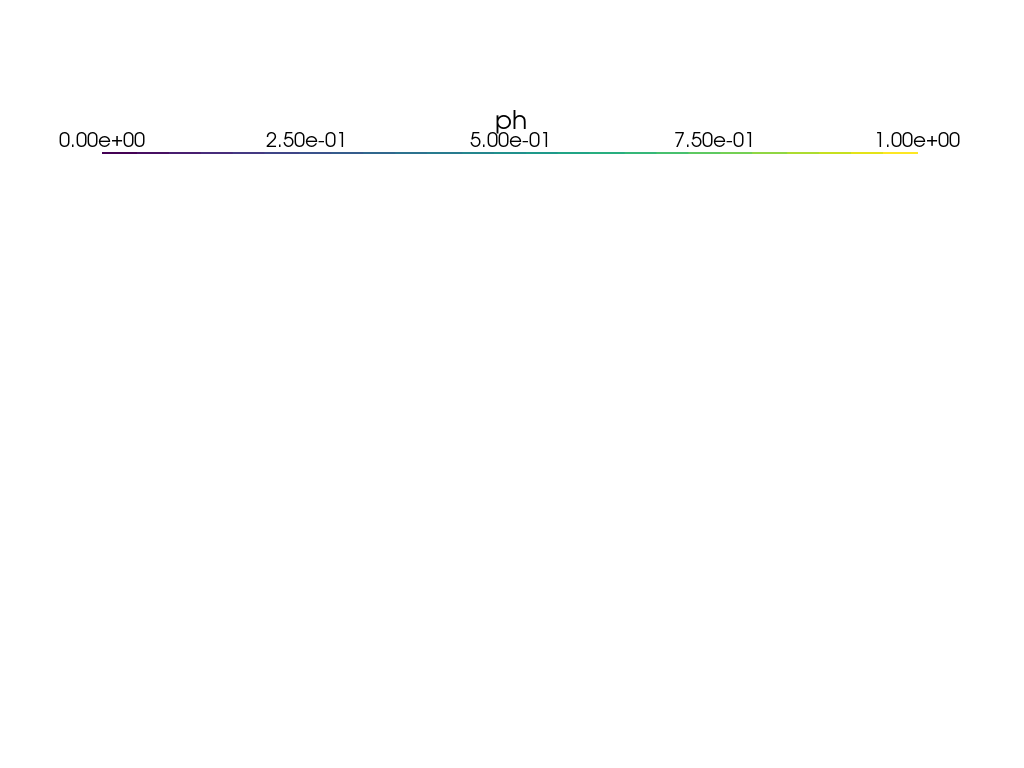

In [ ]:
plotter.show()

In [18]:
import numpy as np
from PIL import Image

#imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
imgs = [Image.fromarray((pp.reshape(11,11,-1)[:,:,1]*100).astype(np.uint8)) for pp in Vv]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", format="GIF", save_all=True, append_images=imgs[1:], duration=100, loop=0)

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


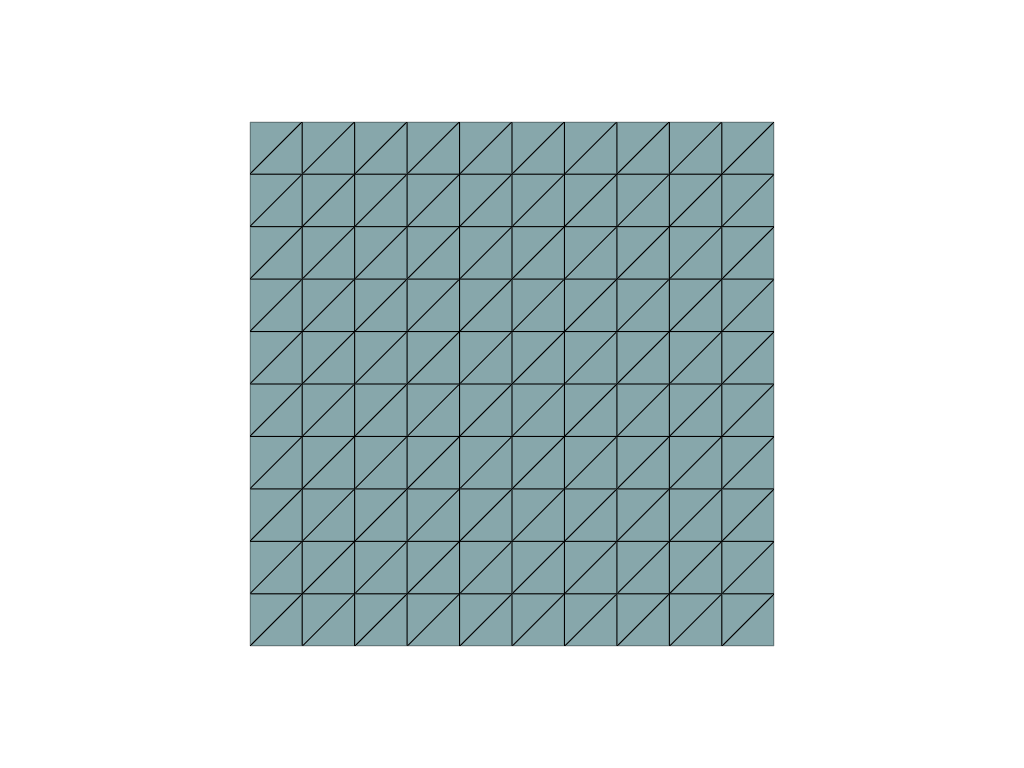

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


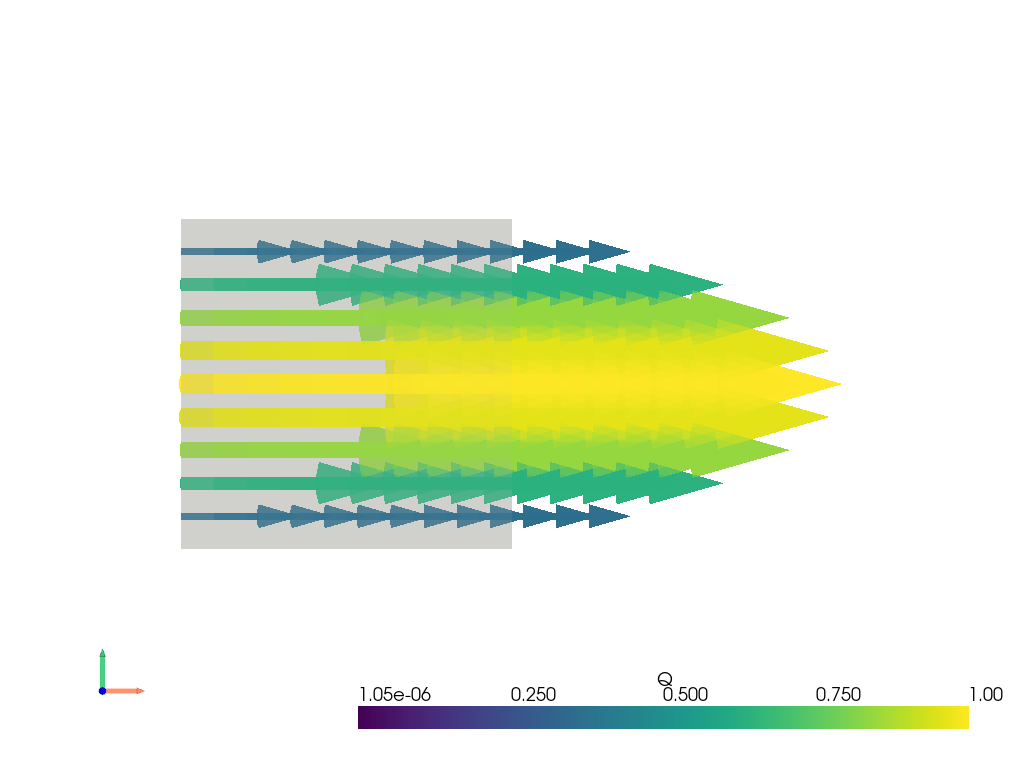

In [32]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
P=Vv[-1]
P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid["P"]=P_
u_grid.set_active_vectors("P")

p = pyvista.Plotter()
p.add_mesh(u_grid.arrows, line_width=0.5,lighting=False,opacity=0.9, scalar_bar_args={"title": "Q"})
p.add_mesh(u_grid, color="grey", ambient=0.6, opacity=0.6, show_edges=False)
_ = p.add_axes(line_width=5, labels_off=True)
p.view_xy()

p.show()

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


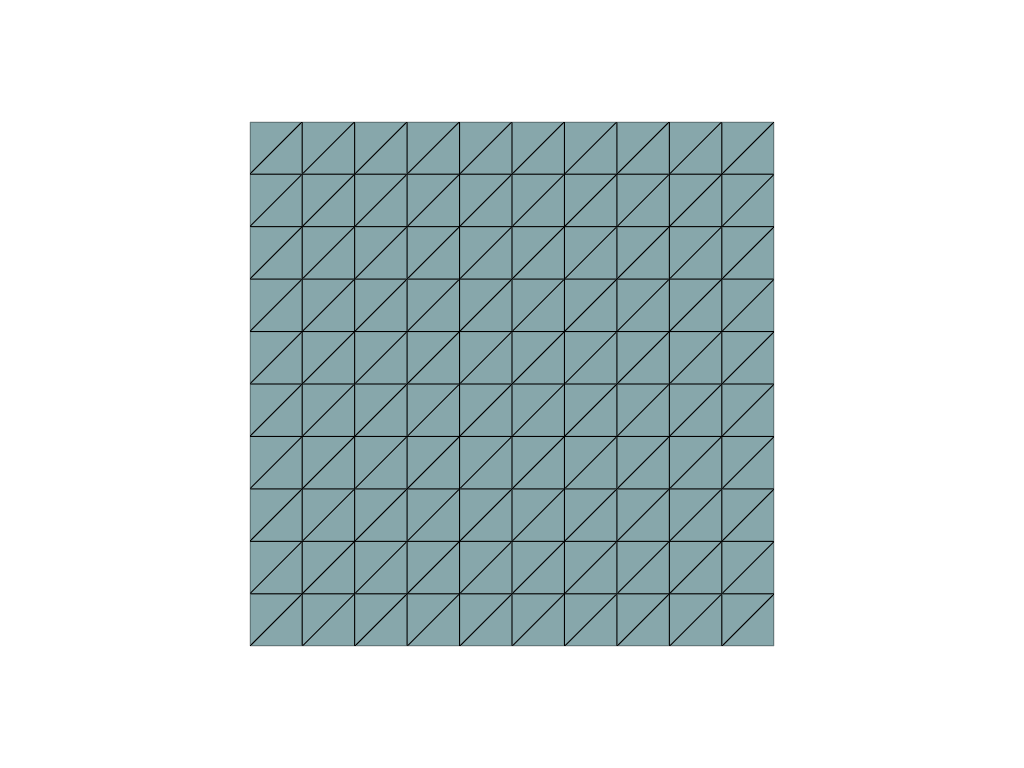

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


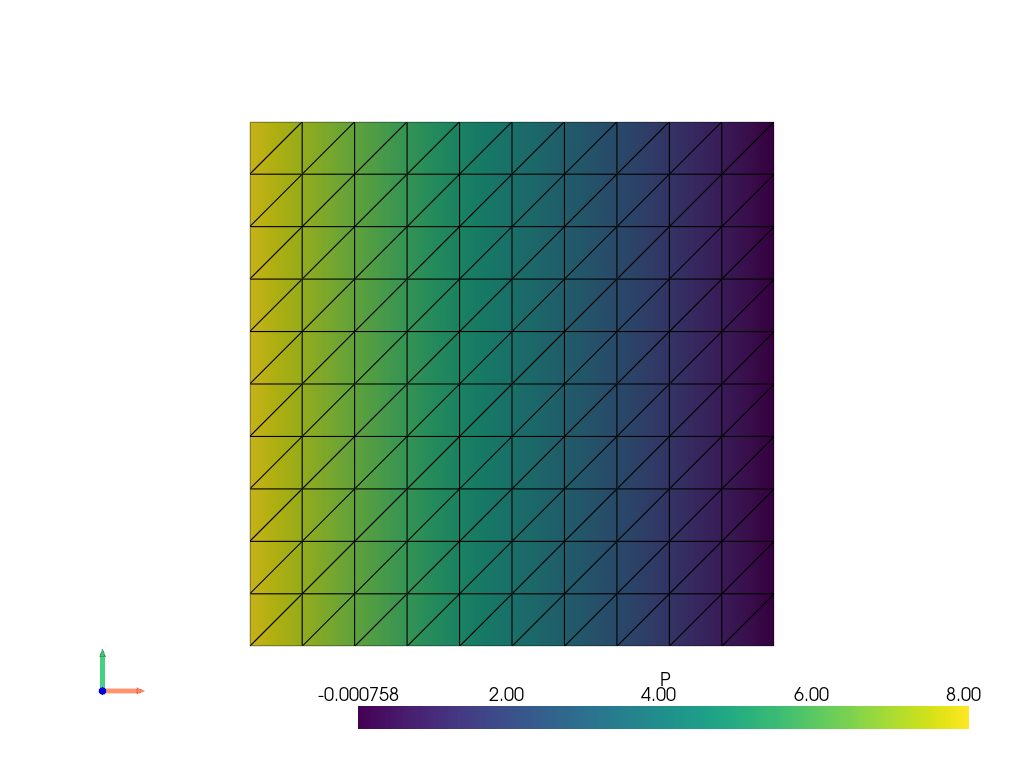

In [38]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=domain
pyvista.start_xvfb()
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
#P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
#P=Pv[-1]
#P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid.point_data["P"]=Pv[2]
u_grid.set_active_scalars("P")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.add_axes(line_width=5, labels_off=True)
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [32]:
#Vv[0].x.array.shape
Vv[0].evaluate?

Signature: Vv[0].evaluate(x, mapping, component, index_values, derivatives=())
Docstring: Get *self* from *mapping* and return the component asked for.
File:      /dolfinx-env/lib/python3.12/site-packages/ufl/core/terminal.py
Type:      method

# Data read

In [3]:
! pwd

/app


In [1]:
import os
#ROOT="/app/Exploring_repo"
ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"
os.listdir(os.path.join(ROOT,"Data"))

['64x64_2D_poisson_eq_Dirichlet_DBC_V_NBC_H.csv',
 '2D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64.csv',
 'PERMI_3_all.h5',
 '3D_poisson_eq_Dirichlet_BC_64x64x64.csv',
 '3D_poisson_eq_Dirichlet_Const_Linear_f_Const_64x64.csv',
 '2D_NS_eq_Dirichlet_Linear_Linear_f_zero_S10x10_T10_500.csv',
 '2D_poisson_eq_Dirichlet_Const_Quad_f_Const_64x64.csv',
 '2D_poisson_eq_Dirichlet_Quad_Quad_f_Const_64x64.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC3.csv',
 '2D_poisson_eq_D_N_R_quad_f_Linear_Linear_64x64.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC_V_BC_H.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC5.csv',
 '64x64_2D_poisson_eq_Dirichlet_BC.csv',
 '2D_poisson_eq_Dirichlet_Exp_Exp_f_Linear_Linear_64x64.csv',
 '32x32_2D_poisson_eq_Dirichlet_BC.csv',
 'PERMI_0_all.h5',
 '64x64_2D_poisson_eq_Dirichlet_BC4.csv',
 '2D_1P_DF_eq_Dirichlet_Linear_Linear_f_zero_S20x20_T10_1000.csv',
 '60x60_T240_2D_2P_Darcy_flow.csv',
 '2D_poisson_eq_Dirichlet_Linear_Linear_f_Const_64x64.csv',
 '32x32_2D_poisson_eq_Dirichlet_BC2.cs

In [2]:
import pandas as pd
import numpy as np

import h5py
filename = os.path.join(ROOT,"Data","PERMI_0_all.h5")

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key]))
    d1=pd.DataFrame(f[a_group_key])

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    #ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['BHP', 'Restrictions', 'features', 'outout']>
<class 'h5py._debian_h5py_serial._hl.group.Group'>


In [3]:
f = h5py.File(filename)

In [4]:
for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key]))

BHP
<class 'h5py._debian_h5py_serial._hl.group.Group'>
Restrictions
<class 'h5py._debian_h5py_serial._hl.group.Group'>
features
<class 'h5py._debian_h5py_serial._hl.group.Group'>
outout
<class 'h5py._debian_h5py_serial._hl.group.Group'>


In [14]:
f = h5py.File(filename)

for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key]))

group = f["features"]
#group = f["outout"]

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

# This assumes group[some_key_inside_the_group] is a dataset, 
# and returns a np.array:
item = group["block0_items"][()]
data = group["block0_values"][()]
#Do whatever you want with data

#After you are done
#f.close()
print(item.shape)
print(data.shape)
cols_list=list(map(lambda c: c.decode("utf-8"),item.tolist()))
pd.DataFrame(
    data=data,
    columns=cols_list
    )


np.unique(np.array(list(map(get_prop,cols_list[:]))))

BHP
<class 'h5py._debian_h5py_serial._hl.group.Group'>
Restrictions
<class 'h5py._debian_h5py_serial._hl.group.Group'>
features
<class 'h5py._debian_h5py_serial._hl.group.Group'>
outout
<class 'h5py._debian_h5py_serial._hl.group.Group'>
axis0
axis1
block0_items
block0_values
(1698,)
(6618, 1698)


array(['FR', 'GridCentroidX', 'GridCentroidY', 'GridThickness', 'GridTop',
       'GrossBlockVolume', 'NetPay', 'NettoGrossRatio', 'OS', 'OV', 'OVF',
       'P', 'PermeabilityI', 'PermeabilityJ', 'PermeabilityK', 'Porosity',
       'SGR', 'WS', 'WV', 'X', 'Y', 'Z', 'completation', 'type', 'well'],
      dtype='<U16')

In [16]:
cols_list[-1]

'WV_240'

In [15]:
get_prop = lambda com_prop: com_prop.split("_")[0]
cols_list=list(map(lambda c: c.decode("utf-8"),item.tolist()))
props=np.unique(np.array(list(map(get_prop,cols_list[18:]))))
t=1
print(list(map(lambda p: p+"_"+str(t),props)))

features_data=pd.DataFrame(
    data=data,
    columns=cols_list
    )

SVP=np.stack(list(map(lambda t: features_data[list(map(lambda p: p+"_"+str(t),props))].values,np.arange(1,241))),axis=2)
print(SVP.shape)

['OS_1', 'OV_1', 'OVF_1', 'P_1', 'SGR_1', 'WS_1', 'WV_1']
(6618, 7, 240)


In [16]:
SVP.shape[0]*SVP.shape[-1]
print(np.unique(features_data.GridCentroidX.values))
print(np.unique(features_data.GridCentroidY.values))
features_data

[  50.  150.  250.  350.  450.  550.  650.  750.  850.  950. 1050. 1150.
 1250. 1350. 1450. 1550. 1650. 1750. 1850. 1950. 2050. 2150. 2250. 2350.
 2450. 2550. 2650. 2750. 2850. 2950. 3050. 3150. 3250. 3350. 3450. 3550.
 3650. 3750. 3850. 3950. 4050. 4150. 4250. 4350. 4450. 4550. 4650. 4750.
 4850. 4950. 5050. 5150. 5250. 5350. 5450. 5550. 5650. 5750. 5850. 5950.]
[-5950. -5850. -5750. -5650. -5550. -5450. -5350. -5250. -5150. -5050.
 -4950. -4850. -4750. -4650. -4550. -4450. -4350. -4250. -4150. -4050.
 -3950. -3850. -3750. -3650. -3550. -3450. -3350. -3250. -3150. -3050.
 -2950. -2850. -2750. -2650. -2550. -2450. -2350. -2250. -2150. -2050.
 -1950. -1850. -1750. -1650. -1550. -1450. -1350. -1250. -1150. -1050.
  -950.  -850.  -750.  -650.  -550.  -450.  -350.  -250.  -150.   -50.]


well  type  completation     X     Y    Z   FR  Porosity  PermeabilityK  \
0      1.0   1.0           1.0   2.0   2.0  1.0  0.0       0.2          100.0   
1      1.0   1.0           0.0   1.0   1.0  1.0  0.0       0.2          100.0   
2      1.0   1.0           0.0   2.0   1.0  1.0  0.0       0.2          100.0   
3      1.0   1.0           0.0   3.0   1.0  1.0  0.0       0.2          100.0   
4      1.0   1.0           0.0   4.0   1.0  1.0  0.0       0.2          100.0   
...    ...   ...           ...   ...   ...  ...  ...       ...            ...   
6613   8.0   0.0           0.0  56.0  50.0  1.0  0.0       0.2         1000.0   
6614   8.0   0.0           0.0  57.0  50.0  1.0  0.0       0.2         1000.0   
6615   8.0   0.0           0.0  58.0  50.0  1.0  0.0       0.2         1000.0   
6616   8.0   0.0           0.0  59.0  50.0  1.0  0.0       0.2         1000.0   
6617   8.0   0.0           0.0  60.0  50.0  1.0  0.0       0.2          100.0   

      NetPay  ...    WS_239  OV_239  WV_239    P_240    OS_240   OVF_240  \
0       25.0  ...  0.435302   1.295    0.32  202.919  0.563836  0.973407   
1       25.0  ...  0.308075   1.295    0.32  214.596  0.691466  0.971869   
2       25.0  ...  0.319478   1.295    0.32  214.477  0.678884  0.971885   
3       25.0  ...  0.335900   1.295    0.32  227.077  0.663302  0.970226   
4       25.0  ...  0.338420   1.295    0.32  239.696  0.660893  0.968564   
...      ...  ...       ...     ...     ...      ...       ...       ...   
6613    25.0  ...  0.561853   1.295    0.32  292.535  0.437890  0.961605   
6614    25.0  ...  0.551611   1.295    0.32  292.526  0.448114  0.961606   
6615    25.0  ...  0.542035   1.295    0.32  292.681  0.457673  0.961586   
6616    25.0  ...  0.522990   1.295    0.32  292.655  0.476657  0.961589   
6617    25.0  ...  0.505927   1.295    0.32  292.021  0.493656  0.961673   

      SGR_240    WS_240  OV_240  WV_240  
0         1.0  0.436164   1.295    0.32  
1         1.0  0.308534   1.295    0.32  
2         1.0  0.321116   1.295    0.32  
3         1.0  0.336698   1.295    0.32  
4         1.0  0.339107   1.295    0.32  
...       ...       ...     ...     ...  
6613      1.0  0.562110   1.295    0.32  
6614      1.0  0.551886   1.295    0.32  
6615      1.0  0.542327   1.295    0.32  
6616      1.0  0.523343   1.295    0.32  
6617      1.0  0.506344   1.295    0.32  

[6618 rows x 1698 columns]

In [17]:
XYKIJ=features_data[["GridCentroidX","GridCentroidY","Z","PermeabilityI","PermeabilityJ","PermeabilityK"]].values

In [18]:
list(features_data.columns)

['well',
 'type',
 'completation',
 'X',
 'Y',
 'Z',
 'FR',
 'Porosity',
 'PermeabilityK',
 'NetPay',
 'PermeabilityJ',
 'GridCentroidY',
 'GridTop',
 'GridThickness',
 'GrossBlockVolume',
 'GridCentroidX',
 'PermeabilityI',
 'NettoGrossRatio',
 'P_1',
 'OS_1',
 'OVF_1',
 'SGR_1',
 'WS_1',
 'OV_1',
 'WV_1',
 'P_2',
 'OS_2',
 'OVF_2',
 'SGR_2',
 'WS_2',
 'OV_2',
 'WV_2',
 'P_3',
 'OS_3',
 'OVF_3',
 'SGR_3',
 'WS_3',
 'OV_3',
 'WV_3',
 'P_4',
 'OS_4',
 'OVF_4',
 'SGR_4',
 'WS_4',
 'OV_4',
 'WV_4',
 'P_5',
 'OS_5',
 'OVF_5',
 'SGR_5',
 'WS_5',
 'OV_5',
 'WV_5',
 'P_6',
 'OS_6',
 'OVF_6',
 'SGR_6',
 'WS_6',
 'OV_6',
 'WV_6',
 'P_7',
 'OS_7',
 'OVF_7',
 'SGR_7',
 'WS_7',
 'OV_7',
 'WV_7',
 'P_8',
 'OS_8',
 'OVF_8',
 'SGR_8',
 'WS_8',
 'OV_8',
 'WV_8',
 'P_9',
 'OS_9',
 'OVF_9',
 'SGR_9',
 'WS_9',
 'OV_9',
 'WV_9',
 'P_10',
 'OS_10',
 'OVF_10',
 'SGR_10',
 'WS_10',
 'OV_10',
 'WV_10',
 'P_11',
 'OS_11',
 'OVF_11',
 'SGR_11',
 'WS_11',
 'OV_11',
 'WV_11',
 'P_12',
 'OS_12',
 'OVF_12',
 'SGR_1

In [19]:
# OV oil viscocity
print(np.unique(SVP[:,1,:]))
# WV oil viscocity
print(np.unique(SVP[:,-1,:]))
# WV oil viscocity
print(np.unique(SVP[:,4,:]))

print(np.unique(features_data.FR.values))
print(np.unique(features_data.Porosity.values))


[1.295]
[0.32]
[1.]
[0.]
[0.2]


In [20]:
print(np.unique(features_data.X.values))
print(np.unique(features_data.GridCentroidX.values))
print(np.unique(features_data.Y.values))
print(np.unique(features_data.PermeabilityK.values))
print(np.unique(features_data.GridCentroidY.values))
print(np.unique(features_data.OS_200.values))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60.]
[  50.  150.  250.  350.  450.  550.  650.  750.  850.  950. 1050. 1150.
 1250. 1350. 1450. 1550. 1650. 1750. 1850. 1950. 2050. 2150. 2250. 2350.
 2450. 2550. 2650. 2750. 2850. 2950. 3050. 3150. 3250. 3350. 3450. 3550.
 3650. 3750. 3850. 3950. 4050. 4150. 4250. 4350. 4450. 4550. 4650. 4750.
 4850. 4950. 5050. 5150. 5250. 5350. 5450. 5550. 5650. 5750. 5850. 5950.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60.]
[ 100. 1000.]
[-5950. -5850. -5750. -5650. -5550. -5450. -5350. -5250. -5150. -5050.
 -4950. -4850. -4750. -4650. -4550. -4450. -4350. -4250. -4

In [35]:
len(features_data.X.values)/239

27.690376569037657

In [23]:
!pip install einops

In [21]:
import pandas as pd
import os
from einops import repeat,rearrange
#['OS_1', 'OV_1', 'OVF_1', 'P_1', 'SGR_1', 'WS_1', 'WV_1']
def solution_data_normalization(Uv,X):
#    Uv_=np.concatenate([Vv_,Pv_],axis=-1)
    X=repeat(X[:,:],"p v -> t p v",t=240)
    T=repeat(np.array([t for t in range(1,241)]),"t -> t p 1",p=X.shape[1])
    XT=np.concatenate([X,T],axis=-1)
    Uv=rearrange(Uv,"p v t-> (t p) v")
    XT=rearrange(XT,"t p v -> (t p) v")

    data_dict={
        "Os":Uv[:,0].tolist(),
        "Bo":Uv[:,2].tolist(),
        "Ws":Uv[:,5].tolist(),
        "P":Uv[:,3].tolist(),
        "x":XT[:,0].tolist(),
        "y":XT[:,1].tolist(),
        "z":XT[:,2].tolist(),
        "Ki":XT[:,3].tolist(),
        "Kj":XT[:,4].tolist(),
        "Kk":XT[:,5].tolist(),
        "t":XT[:,6].tolist()
    }
    return pd.DataFrame(data_dict)


In [22]:
data=solution_data_normalization(SVP,XYKIJ)
data

Os        Bo        Ws        P       x       y    z      Ki  \
0        0.700000  0.967360  0.300000  248.840   150.0  -150.0  1.0   100.0   
1        0.700000  0.967360  0.300000  248.840    50.0   -50.0  1.0   100.0   
2        0.700000  0.967360  0.300000  248.840   150.0   -50.0  1.0   100.0   
3        0.700000  0.967360  0.300000  248.840   250.0   -50.0  1.0   100.0   
4        0.700000  0.967360  0.300000  248.840   350.0   -50.0  1.0   100.0   
...           ...       ...       ...      ...     ...     ...  ...     ...   
1588315  0.437890  0.961605  0.562110  292.535  5550.0 -4950.0  1.0  1000.0   
1588316  0.448114  0.961606  0.551886  292.526  5650.0 -4950.0  1.0  1000.0   
1588317  0.457673  0.961586  0.542327  292.681  5750.0 -4950.0  1.0  1000.0   
1588318  0.476657  0.961589  0.523343  292.655  5850.0 -4950.0  1.0  1000.0   
1588319  0.493656  0.961673  0.506344  292.021  5950.0 -4950.0  1.0   100.0   

             Kj      Kk      t  
0         100.0   100.0    1.0  
1         100.0   100.0    1.0  
2         100.0   100.0    1.0  
3         100.0   100.0    1.0  
4         100.0   100.0    1.0  
...         ...     ...    ...  
1588315  1000.0  1000.0  240.0  
1588316  1000.0  1000.0  240.0  
1588317  1000.0  1000.0  240.0  
1588318  1000.0  1000.0  240.0  
1588319   100.0   100.0  240.0  

[1588320 rows x 11 columns]

In [23]:
XYKIJ.shape

(6618, 6)

In [24]:
data["Ki"].values.shape

(1588320,)

In [26]:
data.to_csv(os.path.join(ROOT,"Data","60x60_T240_2D_2P_Darcy_flow.csv"))

In [27]:
import sympy

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,0.05,0.45,0.5,1e5)
Se_f=lambda sw: sympy.lambdify((Sw,SOR,SWC),Sc)(sw,0.05,0.45)
K_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),K_rw)(sw,0.05,0.45,0.5,1e5,0.3)
K_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),K_ro)(sw,0.05,0.45,0.5,1e5,0.5)

def transform_sw_pt2pa(Sw,pt):
    pc=Pc_f(Sw)
    p_o=(pt+pc)/2
    p_w=(pt-pc)/2
    return p_o,p_w

In [32]:
#data["Po"],data["Pw"]=zip(*(data[["Ws","P"]].apply(transform_sw_pt2pa,axis=1)))
data["Po"],data["Pw"]=transform_sw_pt2pa(data["Ws"],data["P"])
data
#data[["Ws","P"]]

Os        Bo        Ws        P     x     y    z      Ki  \
0        0.700000  0.967360  0.967360  248.840   2.0   2.0  1.0   100.0   
1        0.700000  0.967360  0.967360  248.840   1.0   1.0  1.0   100.0   
2        0.700000  0.967360  0.967360  248.840   2.0   1.0  1.0   100.0   
3        0.700000  0.967360  0.967360  248.840   3.0   1.0  1.0   100.0   
4        0.700000  0.967360  0.967360  248.840   4.0   1.0  1.0   100.0   
...           ...       ...       ...      ...   ...   ...  ...     ...   
1588315  0.437890  0.961605  0.961605  292.535  56.0  50.0  1.0  1000.0   
1588316  0.448114  0.961606  0.961606  292.526  57.0  50.0  1.0  1000.0   
1588317  0.457673  0.961586  0.961586  292.681  58.0  50.0  1.0  1000.0   
1588318  0.476657  0.961589  0.961589  292.655  59.0  50.0  1.0  1000.0   
1588319  0.493656  0.961673  0.961673  292.021  60.0  50.0  1.0   100.0   

             Kj      Kk      t            Po            Pw  
0         100.0   100.0    1.0  46825.219666 -46576.379666  
1         100.0   100.0    1.0  46825.219666 -46576.379666  
2         100.0   100.0    1.0  46825.219666 -46576.379666  
3         100.0   100.0    1.0  46825.219666 -46576.379666  
4         100.0   100.0    1.0  46825.219666 -46576.379666  
...         ...     ...    ...           ...           ...  
1588315  1000.0  1000.0  240.0  47903.643034 -47611.108034  
1588316  1000.0  1000.0  240.0  47903.451838 -47610.925838  
1588317  1000.0  1000.0  240.0  47907.263461 -47614.582461  
1588318  1000.0  1000.0  240.0  47906.690314 -47614.035314  
1588319   100.0   100.0  240.0  47890.693217 -47598.672217  

[1588320 rows x 13 columns]

In [62]:
np.min(data[["x","y","P","t"]].y.values/50)
np.max(data[["x","y","P","t"]].y.values/50)

def prop_to_time_tensor_prop(xytp):
    xytp.x=((xytp.x.values/50-1)*0.5).astype(int)-1
    xytp.y=(np.abs(xytp.y.values/50-1)*0.5).astype(int)-1
    xytp.t=(xytp.t.values-1).astype(int)-1
    [np.stack((xytp.x.values,xytp.y.values))]


    print(xytp.x.max()+1,xytp.y.max()+1,xytp.t.max()+1)
    data_tensor=np.ndarray([xytp.x.max()+1,xytp.y.max()+1,xytp.t.max()+1])
    print(data_tensor[xytp.x.values.astype(int),xytp.y.values.astype(int),xytp.t.values.astype(int)])
    data_tensor[xytp.x.values.astype(int),xytp.y.values.astype(int),xytp.t.values.astype(int)]=xytp.Os.values
    #data_tensor[x[["x","y","t"]].values]=xytp.P.values
    #for v in xytp.values:
    #    print(v)
    #    x,y,p,t=tuple(v)
    #    
    #    data_tensor[int(x),int(y),int(t)]=p

    return data_tensor,xytp

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [29]:
x,xy=prop_to_time_tensor_prop(data[["x","y","Os","t"]])
xy.values
print(xy[["x","y","t"]].values.astype(int).max(axis=0))
#x[xy[["x","y","t"]].values.astype(int)]

#xy.x.max()


59 60 239
[6.42e-323 3.95e-323 7.91e-323 ... 2.27e-322 2.96e-323 5.93e-323]
[ 58  59 238]


/tmp/ipykernel_148798/618236010.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xytp.x=((xytp.x.values/50-1)*0.5).astype(int)-1
/tmp/ipykernel_148798/618236010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xytp.y=(np.abs(xytp.y.values/50-1)*0.5).astype(int)-1
/tmp/ipykernel_148798/618236010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


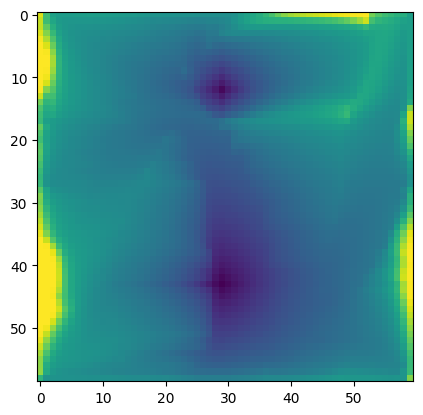

In [30]:
import matplotlib.pyplot as plt
plt.imshow(x[:,:,-1])

846060

In [31]:
x.shape

(59, 60, 239)

In [43]:
data.P.values==0

array([False, False, False, ..., False, False, False])

In [28]:
import numpy as np
a=np.ndarray((4,4))
print(a)
a[np.random.randint(0,2,(3,1)),np.random.randint(0,2,(3,1))]=np.random.randint(0,5,(3,1))
print(a)

[[1.00000000e+000 1.00000000e+000 2.22728713e-284 1.35467034e-043]
 [1.00000000e+000 1.00000000e+000 2.22728713e-284 1.35467034e-043]
 [6.17331270e+303 2.05025655e-077 2.22728713e-284 1.35467034e-043]
 [6.17331270e+303 2.05025655e-077 2.22728713e-284 1.35467034e-043]]
[[3.00000000e+000 1.00000000e+000 2.22728713e-284 1.35467034e-043]
 [1.00000000e+000 0.00000000e+000 2.22728713e-284 1.35467034e-043]
 [6.17331270e+303 2.05025655e-077 2.22728713e-284 1.35467034e-043]
 [6.17331270e+303 2.05025655e-077 2.22728713e-284 1.35467034e-043]]


In [83]:
for i in zip(x.values.tolist()):
    print(i)

([2.0, 4.0, 248.84, 1.0],)
([0.0, 2.0, 248.84, 1.0],)
([2.0, 2.0, 248.84, 1.0],)
([4.0, 2.0, 248.84, 1.0],)
([6.0, 2.0, 248.84, 1.0],)
([8.0, 2.0, 248.84, 1.0],)
([10.0, 2.0, 248.84, 1.0],)
([12.0, 2.0, 248.84, 1.0],)
([14.0, 2.0, 248.84, 1.0],)
([16.0, 2.0, 248.84, 1.0],)
([18.0, 2.0, 248.84, 1.0],)
([20.0, 2.0, 248.84, 1.0],)
([22.0, 2.0, 248.84, 1.0],)
([24.0, 2.0, 248.84, 1.0],)
([26.0, 2.0, 248.84, 1.0],)
([28.0, 2.0, 248.84, 1.0],)
([30.0, 2.0, 248.84, 1.0],)
([32.0, 2.0, 248.84, 1.0],)
([34.0, 2.0, 248.84, 1.0],)
([36.0, 2.0, 248.84, 1.0],)
([38.0, 2.0, 248.84, 1.0],)
([40.0, 2.0, 248.84, 1.0],)
([42.0, 2.0, 248.84, 1.0],)
([0.0, 4.0, 248.84, 1.0],)
([2.0, 4.0, 248.84, 1.0],)
([4.0, 4.0, 248.84, 1.0],)
([6.0, 4.0, 248.84, 1.0],)
([8.0, 4.0, 248.84, 1.0],)
([10.0, 4.0, 248.84, 1.0],)
([12.0, 4.0, 248.84, 1.0],)
([14.0, 4.0, 248.84, 1.0],)
([16.0, 4.0, 248.84, 1.0],)
([18.0, 4.0, 248.84, 1.0],)
([20.0, 4.0, 248.84, 1.0],)
([22.0, 4.0, 248.84, 1.0],)
([24.0, 4.0, 248.84, 1.0],)
([2

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [72]:
x.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 